# Titanic

In [59]:
from pandas import DataFrame, Series, crosstab
import numpy as np
from collections import Counter
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from datetime import datetime, timedelta
from sklearn import tree
import graphviz 

<br>
<br>
### Loding training data and testing data
* PassengerId => 乘客ID
* Pclass => 乘客等級(1/2/3等艙位)
* Name => 乘客姓名
* Sex => 性別
* Age => 年齡
* SibSp => 堂兄弟/妹個數
* Parch => 父母與小孩個數
* Ticket => 船票信息
* Fare => 票價
* Cabin => 客艙
* Embarked => 登船港口

In [43]:
df = DataFrame.from_csv("res/train.csv")
test = DataFrame.from_csv("res/test.csv")
df[:3]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<br>
## Feature exploration

<br>
<b> Sex

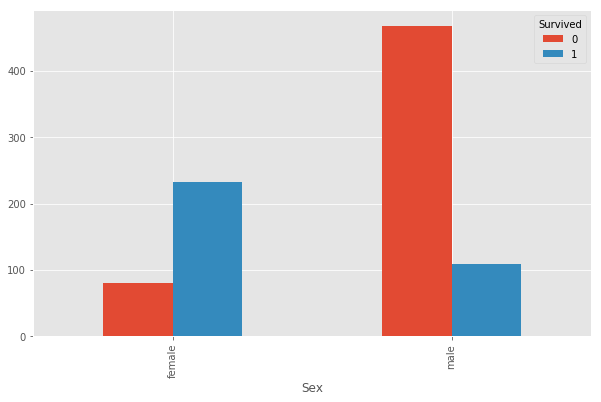

In [24]:
df_sex = crosstab(df['Sex'], df['Survived'])
df_sex.plot(kind='bar', figsize=(10,6))
# 印出關聯性大小 (correlation or sth.)

<br>
<b> Pclass

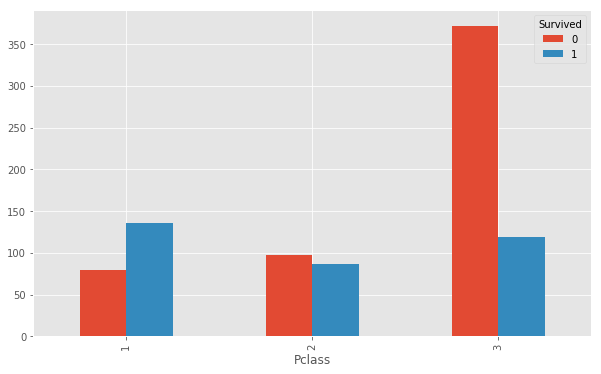

In [54]:
df_pclass = crosstab(df['Pclass'], df['Survived'])
df_pclass.plot(kind='bar', figsize=(10,6))

<br>
<b> SibSp

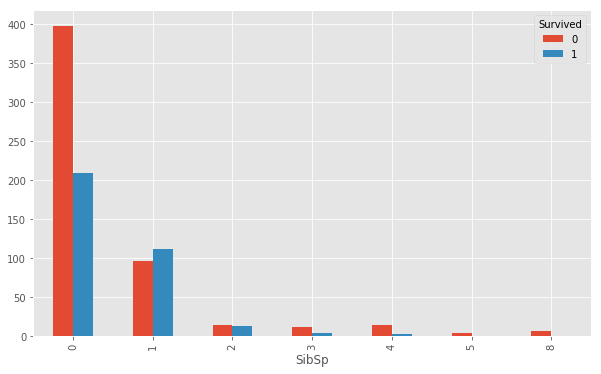

In [53]:
df_sibsp = crosstab(df['SibSp'], df['Survived'])
df_sibsp.plot(kind='bar', figsize=(10,6))

<br>
<b>Age

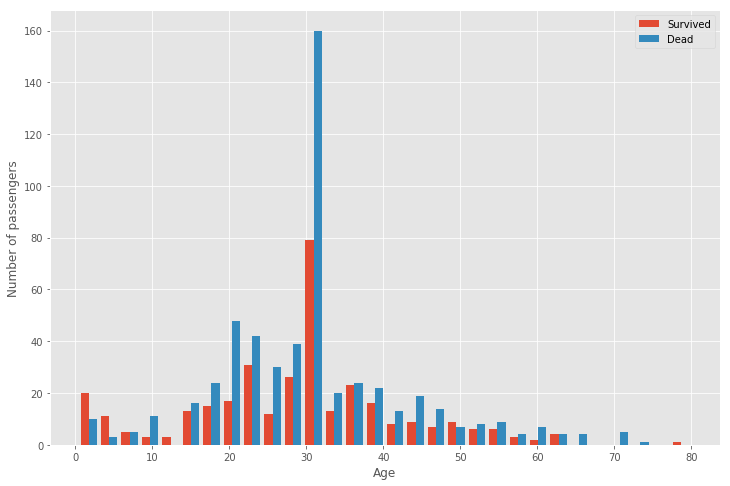

In [52]:
df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Dead'] = (df['Survived'] == 0).astype(int)
figure = plt.figure(figsize=(12,8))
plt.hist([df[df['Survived']==1]['Age'], df[df['Survived']==0]['Age']],
          bins = 30,label = ['Survived','Dead'])

plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

<br>
<b>Fare

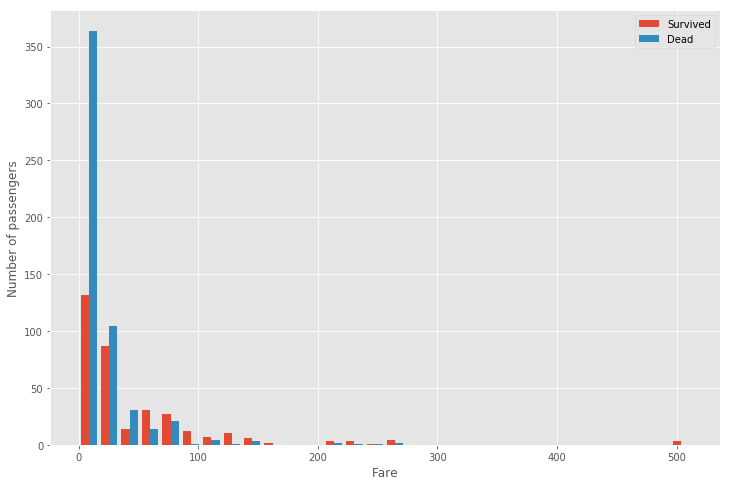

In [48]:
df['Dead'] = (df['Survived'] == 0).astype(int)
figure = plt.figure(figsize=(12,8))
plt.hist([df[df['Survived']==1]['Fare'], df[df['Survived']==0]['Fare']],
          bins = 30,label = ['Survived','Dead'])

plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()
del df['Dead']

In [38]:
def sex_translate(x):
    if x == 'male': return 0
    else: return 1
    
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.0,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,1.0,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,0.0,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,1.0,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,1.0,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,1.0,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,1.0,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,1.0,80.000000,8.000000,6.000000,512.329200


<br>
### Feature Process

In [56]:
def preprocess(df):
    df['Sex'] = df['Sex'].fillna(df['Sex'].mode()).apply(sex_translate)
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['SibSp'] = df['SibSp'].fillna(df['SibSp'].mean())
    df['Pclass'] = df['Pclass'].fillna(df['Pclass'].mean())
    return df

label_column = 'Survived'
explore_feature = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

In [72]:
train_size = 8/10 * len(df)

train_data = preprocess(df.loc[:train_size, explore_feature])
dev_data = preprocess(df.loc[train_size:, explore_feature])
test_data = preprocess(test.loc[:, explore_feature])

train_label = df.loc[:train_size, 'Survived']
dev_label = df.loc[train_size:, 'Survived']

train_data[:3]

,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,,,,,,
1,3,1,22.0,1,0,7.2500
2,1,1,38.0,1,0,71.2833
3,3,1,26.0,0,0,7.9250


<br>
### Tree

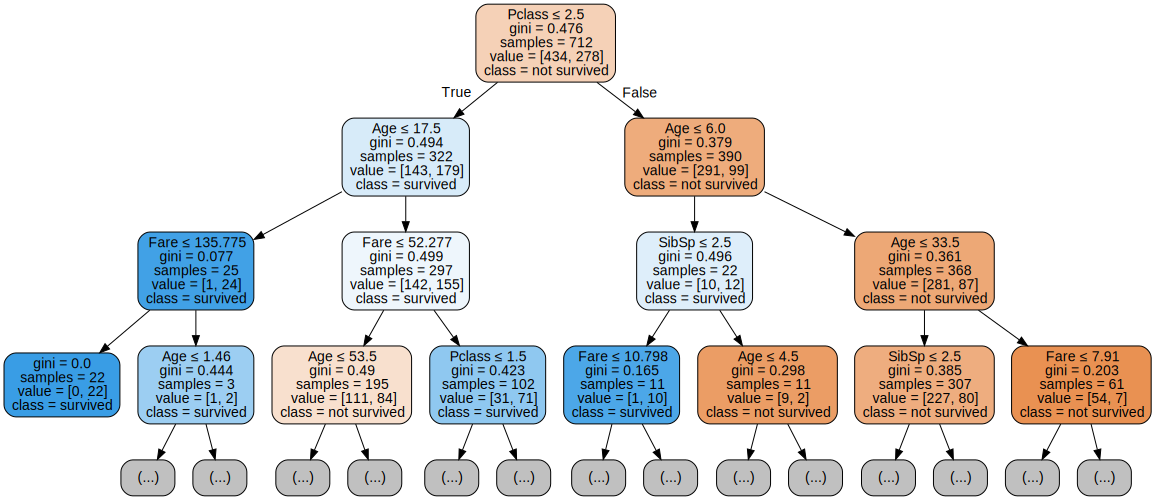

In [73]:
class_name = ['not survived', 'survived']

clf = tree.DecisionTreeClassifier()    # (criterion='entropy')
clf = clf.fit(train_data.as_matrix(), train_label)

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=train_data.columns,  
                         class_names=class_name,  
                         filled=True, rounded=True,  
                         special_characters=True, max_depth=3)  
graph = graphviz.Source(dot_data)  
graph.render("tree") 
graph

In [130]:
dev_result = clf.predict(dev_data.as_matrix())
dev_result = DataFrame(dev_result, index=dev_data.index, columns=['Survived'])

dev_counter = Counter([x==y for x, y in zip(dev_result['Survived'], dev_label)])
dev_acc = dev_counter[1] / sum(dev_counter.values())
print("dev-set accuracy: %0.2f" % (dev_acc*100))

dev-set accuracy: 63.69


In [132]:
test_result = clf.predict(test_data.as_matrix())
result = DataFrame(test_result, index=test_data.index, columns=['Survived'])
result.to_csv('result.csv')